In [5]:
import sys
sys.path.append('../')

import numpy as np
import sqlite3
import pandas as pd

from src.cmesrc.config import CMESRCV3_DB, GENERAL_DATASET, SDOML_DATASET

In [21]:
conn = sqlite3.connect(CMESRCV3_DB)
cur = conn.cursor()

In [22]:
# Starting point

start_harpnums = cur.execute("SELECT COUNT(DISTINCT harpnum) FROM HARPS").fetchone()[0]
start_cmes = cur.execute("SELECT COUNT(*) FROM CMES").fetchone()[0]

start_harpnums, start_cmes

(4098, 32684)

In [23]:
# Pre-processign

# Substep: Removing big harps

big_harps_removed_harps = cur.execute("SELECT COUNT(*) FROM HARPS WHERE area < 18").fetchone()[0]

big_harps_removed_cmes = start_cmes # Unchanged

big_harps_removed_harps, big_harps_removed_cmes

(4096, 32684)

In [24]:
# Substep: Removing overlaps

removed_overlaps_harps = cur.execute("SELECT COUNT(DISTINCT harpnum) FROM PROCESSED_HARPS_BBOX").fetchone()[0]
removed_overlaps_cmes = start_cmes # Unchanged

removed_overlaps_harps, removed_overlaps_cmes

(3655, 32684)

In [25]:
# Step: Associating CMEs to harps

# Substep: Choose CMEs with happened during period HARPs exist

cme_harps_harps = removed_overlaps_harps

cme_harps_cmes = cur.execute("SELECT COUNT(*) FROM CMES WHERE cme_date BETWEEN (SELECT MIN(start) FROM HARPS) AND (SELECT MAX(END) FROM HARPS)").fetchone()[0]

cme_harps_harps, cme_harps_cmes

(3655, 14507)

In [26]:
# Substep: CMEs with spatiotemporally matching regions

cme_harps_matching_harps = cme_harps_harps

cme_harps_matching_cmes = cur.execute("SELECT COUNT(DISTINCT cme_id) FROM CMES_HARPS_SPATIALLY_CONSIST").fetchone()[0]

cme_harps_matching_harps, cme_harps_matching_cmes

(3655, 3755)

In [27]:
# Substep: Match using score criteria

cme_harps_score_harps = cme_harps_matching_harps
cme_harps_score_cmes = cur.execute("SELECT COUNT(DISTINCT cme_id) FROM FINAL_CME_HARP_ASSOCIATIONS").fetchone()[0]

cme_harps_score_harps, cme_harps_score_cmes

(3655, 1001)

In [28]:
# Now put this in a nice table
# with this columns
# | Step | Substep | CMEs | SHARP regions |

import pandas as pd

df = pd.DataFrame(columns=['Step', 'Substep', 'CMEs', 'SHARP regions'])

df.loc[0] = ['Starting point', '', start_cmes, start_harpnums]
df.loc[1] = ['Pre-processing', 'Removing big harps', big_harps_removed_cmes, big_harps_removed_harps]
df.loc[2] = ['Pre-processing', 'Removing overlaps', removed_overlaps_cmes, removed_overlaps_harps]
df.loc[3] = ['Matching', 'CMEs during HARPs exist', cme_harps_cmes, cme_harps_harps]
df.loc[4] = ['Matching', 'Spatiotemporally matching regions', cme_harps_matching_cmes, cme_harps_matching_harps]
df.loc[5] = ['Matching', 'Match criteria', cme_harps_score_cmes, cme_harps_score_harps]

# Now print in markdown

print(df.to_markdown(index=False))


| Step           | Substep                           |   CMEs |   SHARP regions |
|:---------------|:----------------------------------|-------:|----------------:|
| Starting point |                                   |  32684 |            4098 |
| Pre-processing | Removing big harps                |  32684 |            4096 |
| Pre-processing | Removing overlaps                 |  32684 |            3655 |
| Matching       | CMEs during HARPs exist           |  14507 |            3655 |
| Matching       | Spatiotemporally matching regions |   3755 |            3655 |
| Matching       | Match criteria                    |   1001 |            3655 |


In [29]:
gd_conn = sqlite3.connect(GENERAL_DATASET)
gd_cur = gd_conn.cursor()

In [30]:
# Now let's go to the general dataset

# Step: Start

start_harpnums = cme_harps_score_harps
start_cmes = cme_harps_score_cmes

start_harpnums, start_cmes

(3655, 1001)

In [31]:
# Step: Generating dataset

# Substed: BBoxes within 70 degrees

bboxes_70_harps = cur.execute("SELECT COUNT(DISTINCT harpnum) FROM PROCESSED_HARPS_BBOX WHERE LONDTMIN > -70 AND LONDTMAX < 70").fetchone()[0]
bboxes_70_cmes = start_cmes

bboxes_70_harps, bboxes_70_cmes

(3553, 1001)

In [32]:
# Substep: Extract sequences

sequences_harps = gd_cur.execute("SELECT COUNT(DISTINCT harpnum) FROM GENERAL_DATASET").fetchone()[0]
sequences_cmes = gd_cur.execute("SELECT COUNT(DISTINCT cme_id) FROM GENERAL_DATASET WHERE cme_id IS NOT NULL").fetchone()[0]

sequences_harps, sequences_cmes

(3551, 498)

In [33]:
# Same in nice table

df = pd.DataFrame(columns=['Step', 'Substep', 'CMEs', 'SHARP regions'])

df.loc[0] = ['Starting point', '', start_cmes, start_harpnums]
df.loc[1] = ['Generating dataset', 'BBoxes within 70 degrees', bboxes_70_cmes, bboxes_70_harps]
df.loc[2] = ['Generating dataset', 'Extract sequences', sequences_cmes, sequences_harps]

# Now print in markdown

print(df.to_markdown(index=False))


| Step               | Substep                  |   CMEs |   SHARP regions |
|:-------------------|:-------------------------|-------:|----------------:|
| Starting point     |                          |   1001 |            3655 |
| Generating dataset | BBoxes within 70 degrees |   1001 |            3553 |
| Generating dataset | Extract sequences        |    498 |            3551 |


In [34]:
sd_conn = sqlite3.connect(SDOML_DATASET)
sd_cur = sd_conn.cursor()

In [35]:
start_harpnums = sequences_harps
start_cmes = sequences_cmes

start_harpnums, start_cmes

(3551, 498)

In [36]:
# Step: Pre-processing

# Substep: Need images and hourly

# This isn't correct because HOURLY doesn't have the criteria for the sequences, in any case
# 2692, 2699 and 2700 are gone because there aren't any images for a couple of days so well
# 3230 just has 48 or 36 minute images (3 or 4 so no hourly)
# 4345 has a single :48 image so gone too

im_harps = sd_cur.execute("SELECT COUNT( DISTINCT harpnum) FROM HOURLY_PIXEL_BBOX").fetchone()[0]
im_cmes = sd_cur.execute("SELECT COUNT(DISTINCT cme_id) FROM GENERAL_DATASET WHERE cme_id IS NOT NULL AND harpnum IN (SELECT DISTINCT harpnum FROM HOURLY_PIXEL_BBOX)").fetchone()[0]

im_harps, im_cmes

(3548, 498)

In [37]:
# Substep: Removing overlaps

sd_cur.executescript("""
CREATE TEMP TABLE IF NOT EXISTS ignore_harps AS
    SELECT 
       CASE 
           WHEN harpnum_a_cme THEN harpnum_b 
           ELSE harpnum_a 
       END AS to_ignore 
FROM PIXEL_OVERLAPS
WHERE harpnum_a_cme != harpnum_b_cme 
  AND mean_overlap > 30 
  AND ocurrence_percentage > 30
ORDER BY harpnum_a, harpnum_b ASC;

CREATE TEMP TABLE IF NOT EXISTS no_overlap_harps AS
    SELECT DISTINCT harpnum 
    FROM HOURLY_PIXEL_BBOX 
    WHERE harpnum NOT IN (SELECT to_ignore FROM ignore_harps);
""")

ov_harps = sd_cur.execute("SELECT COUNT(*) FROM no_overlap_harps").fetchone()[0]
ov_cmes = sd_cur.execute("SELECT COUNT(DISTINCT cme_id) FROM GENERAL_DATASET INNER JOIN no_overlap_harps ON GENERAL_DATASET.harpnum = no_overlap_harps.harpnum WHERE cme_id IS NOT NULL").fetchone()[0]

ov_harps, ov_cmes

(3416, 498)

In [39]:
# Substep: Remove small harps

sm_harps = sd_cur.execute("SELECT COUNT(DISTINCT harpnum) FROM ACCEPTED_HARPS").fetchone()[0]
sm_cmes = sd_cur.execute("SELECT COUNT(DISTINCT cme_id) FROM GENERAL_DATASET INNER JOIN ACCEPTED_HARPS AH ON GENERAL_DATASET.harpnum = AH.harpnum WHERE cme_id IS NOT NULL").fetchone()[0]

sm_harps, sm_cmes

(2137, 493)

In [40]:
# Step: Adjust General Dataset

f_harps = sd_cur.execute("SELECT COUNT(DISTINCT harpnum) FROM SDOML_DATASET").fetchone()[0]
f_cmes = sd_cur.execute("SELECT COUNT(DISTINCT cme_id) FROM SDOML_DATASET WHERE cme_id IS NOT NULL").fetchone()[0]

f_harps, f_cmes

(1914, 429)

In [41]:
# Same in nice table

df = pd.DataFrame(columns=['Step', 'Substep', 'CMEs', 'SHARP regions'])

df.loc[0] = ['Starting point', '', start_cmes, start_harpnums]
df.loc[1] = ['Pre-processing', 'Need images and hourly', im_cmes, im_harps]
df.loc[2] = ['Pre-processing', 'Removing overlaps', ov_cmes, ov_harps]
df.loc[3] = ['Pre-processing', 'Remove small harps', sm_cmes, sm_harps]
df.loc[4] = ['Adjust General Dataset', '', f_cmes, f_harps]

# Now print in markdown

print(df.to_markdown(index=False))

| Step                   | Substep                |   CMEs |   SHARP regions |
|:-----------------------|:-----------------------|-------:|----------------:|
| Starting point         |                        |    498 |            3551 |
| Pre-processing         | Need images and hourly |    498 |            3548 |
| Pre-processing         | Removing overlaps      |    498 |            3416 |
| Pre-processing         | Remove small harps     |    493 |            2137 |
| Adjust General Dataset |                        |    429 |            1914 |


In [42]:
# Now I just want a better description of the splits so let's gather some data

df = pd.read_sql("""
SELECT * FROM SDOML_DATASET
INNER JOIN SDOML_HARPS ON SDOML_DATASET.harpnum = SDOML_HARPS.harpnum
INNER JOIN SDOML_GROUPS ON SDOML_HARPS.group_id = SDOML_GROUPS.group_id
""", sd_conn)

,slice_id,harpnum,lead_in_start,lead_in_end,obs_start,obs_end,pred_start,pred_end,prev_cme_id,prev_cme_diff,...,pix_area,group_id,group_id,group_size,n_level_1,n_level_2,n_level_3,n_level_4,n_level_5,split
0,1,1,2010-05-01 00:00:00,2010-05-02 08:30:00,2010-05-02 08:30:00,2010-05-03 08:30:00,2010-05-03 08:30:00,2010-05-11 16:12:00,NaN,NaN,...,1711,908,908,1,0,0,0,0,0,4
1,2,1,2010-05-01 00:00:00,2010-05-02 09:30:00,2010-05-02 09:30:00,2010-05-03 09:30:00,2010-05-03 09:30:00,2010-05-11 16:12:00,NaN,NaN,...,1711,908,908,1,0,0,0,0,0,4
2,3,1,2010-05-01 00:00:00,2010-05-02 10:30:00,2010-05-02 10:30:00,2010-05-03 10:30:00,2010-05-03 10:30:00,2010-05-11 16:12:00,NaN,NaN,...,1711,908,908,1,0,0,0,0,0,4
3,4,1,2010-05-01 00:00:00,2010-05-02 11:30:00,2010-05-02 11:30:00,2010-05-03 11:30:00,2010-05-03 11:30:00,2010-05-11 16:12:00,NaN,NaN,...,1711,908,908,1,0,0,0,0,0,4
4,5,1,2010-05-01 00:00:00,2010-05-02 12:30:00,2010-05-02 12:30:00,2010-05-03 12:30:00,2010-05-03 12:30:00,2010-05-11 16:12:00,NaN,NaN,...,1711,908,908,1,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254171,373431,7331,2018-12-30 14:30:00,2019-01-03 06:30:00,2019-01-03 06:30:00,2019-01-04 06:30:00,2019-01-04 06:30:00,2019-01-07 03:00:00,NaN,NaN,...,1225,1914,1914,1,0,0,0,0,0,4
254172,373432,7331,2018-12-30 14:30:00,2019-01-03 07:30:00,2019-01-03 07:30:00,2019-01-04 07:30:00,2019-01-04 07:30:00,2019-01-07 03:00:00,NaN,NaN,...,1225,1914,1914,1,0,0,0,0,0,4
254173,373433,7331,2018-12-30 14:30:00,2019-01-03 08:30:00,2019-01-03 08:30:00,2019-01-04 08:30:00,2019-01-04 08:30:00,2019-01-07 03:00:00,NaN,NaN,...,1225,1914,1914,1,0,0,0,0,0,4
254174,373434,7331,2018-12-30 14:30:00,2019-01-03 09:30:00,2019-01-03 09:30:00,2019-01-04 09:30:00,2019-01-04 09:30:00,2019-01-07 03:00:00,NaN,NaN,...,1225,1914,1914,1,0,0,0,0,0,4


In [46]:
# Now, I want to know the number of positive and negative rows (label) per split

nrows = df.groupby(['split', 'label']).size().reset_index(name='counts')

n_rows_pivot = pd.pivot_table(nrows, values='counts', index=['split'], columns=['label'], aggfunc=np.sum)

# Print in markdown

print(n_rows_pivot.to_markdown())

|   split |     0 |    1 |
|--------:|------:|-----:|
|       1 | 44147 | 5780 |
|       2 | 46611 | 6200 |
|       3 | 45154 | 6057 |
|       4 | 42944 | 6083 |
|       5 | 45164 | 6036 |


In [50]:
# Now the number of CMEs per split by verification level

ncmes = df[df["label"].astype(bool)].drop_duplicates(subset=['cme_id']).groupby(['split', 'verification_level']).size().reset_index(name='counts')

ncmes_pivot = pd.pivot_table(ncmes, values='counts', index=['split'], columns=['verification_level'], aggfunc=np.sum)

# To markdown

print(ncmes_pivot.to_markdown())

|   split |   1.0 |   2.0 |   3.0 |   4.0 |   5.0 |
|--------:|------:|------:|------:|------:|------:|
|       1 |     7 |     6 |    10 |    37 |    28 |
|       2 |     7 |     6 |    10 |    36 |    28 |
|       3 |     7 |     6 |     9 |    36 |    28 |
|       4 |     6 |     6 |     9 |    36 |    28 |
|       5 |     6 |     5 |     9 |    36 |    27 |


In [53]:
# Now number of cme productive and non cme productive regions per split

nreg = df.sort_values(by="label", ascending=False).drop_duplicates(subset=['harpnum'], keep="first").groupby(['split', 'label']).size().reset_index(name='counts')

nreg_pivot = pd.pivot_table(nreg, values='counts', index=['split'], columns=['label'], aggfunc=np.sum)

# To markdown

print(nreg_pivot.to_markdown())

|   split |   0 |   1 |
|--------:|----:|----:|
|       1 | 311 |  72 |
|       2 | 315 |  68 |
|       3 | 315 |  68 |
|       4 | 317 |  66 |
|       5 | 318 |  64 |


In [7]:
df = pd.read_csv("/home/julio/Downloads/pivots.csv")
df

,split,subsplit,neg_row,pos_row,n_cme_level_1,n_cme_level_2,n_cme_level_3,n_cme_level_4,n_cme_level_5,neg_reg,pos_reg
0,1,1,22683,3191,4,3,5,18,14,159,33
1,1,2,22380,2632,4,3,5,19,14,157,35
2,2,1,21085,3062,3,3,5,18,14,156,36
3,2,2,23257,2871,4,3,5,18,14,159,33
4,3,1,22817,2869,3,3,5,18,14,158,33
5,3,2,22049,3600,3,3,5,18,14,158,33
6,4,1,22277,2816,3,3,4,18,14,156,35
7,4,2,22111,3058,3,3,5,18,14,155,36
8,5,1,23056,2980,3,2,4,18,13,159,32
9,5,2,22305,3077,3,3,4,18,14,159,32


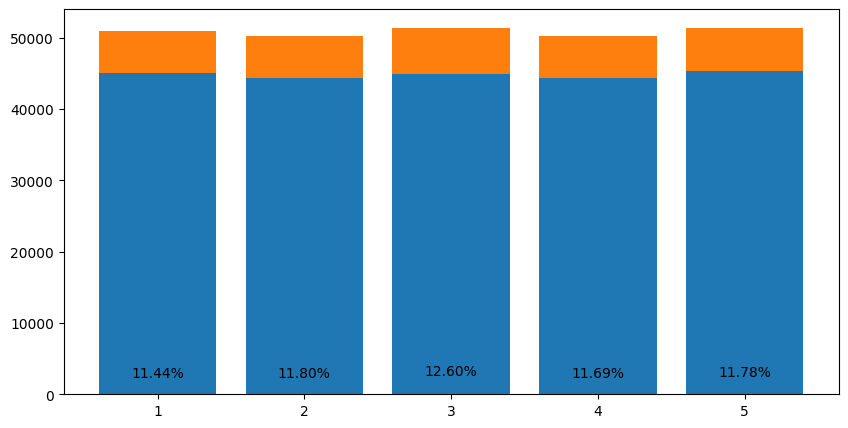

In [15]:
# Hist plot, by split value plot neg_row, pos_row

import matplotlib.pyplot as plt

# Since there are subsplits we need to group by split and add together

nrowdf = df.groupby(['split']).sum().reset_index()

fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(nrowdf["split"], nrowdf["neg_row"], label="Negative rows")
ax.bar(nrowdf["split"], nrowdf["pos_row"], bottom=nrowdf["neg_row"], label="Positive rows")

# And we also want to plot the string % of positive for each split in number

for i, v in enumerate(nrowdf["pos_row"]):
    ax.text(i+1, v/2, "{:.2f}%".format(v/(v+nrowdf["neg_row"][i])*100), ha='center', va='center', fontsize=10)

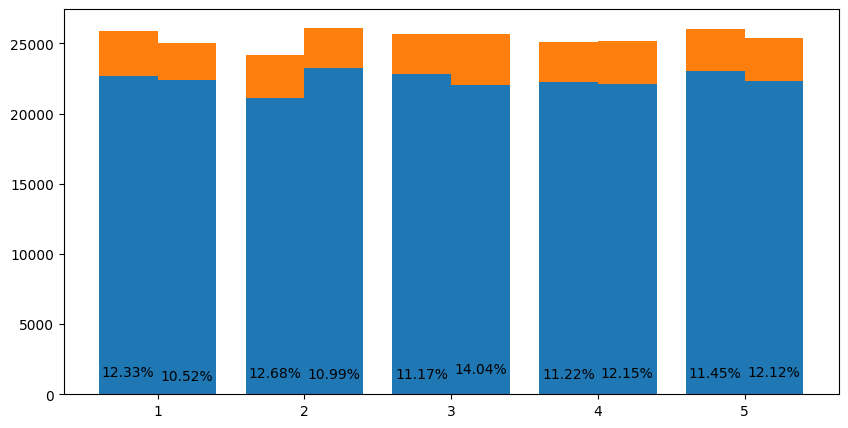

In [22]:
# Now let's do the same by split-subsplit combination but remember we want same split columns to be closer

fig, ax = plt.subplots(figsize=(10, 5))

# No need to group now, but we need to consider the split-subsplit combination when plotting

width = 0.4

ax.bar(df["split"] + (df["subsplit"]-1.5)*width, df["neg_row"], label="Negative rows", width=width)
ax.bar(df["split"] + (df["subsplit"]-1.5)*width, df["pos_row"], bottom=df["neg_row"], label="Positive rows", width=width)

# Now % of positive

for i, v in enumerate(df["pos_row"]):
    ax.text(df["split"][i] + (df["subsplit"][i]-1.5)*width, v/2, "{:.2f}%".format(v/(v+df["neg_row"][i])*100), ha='center', va='center', fontsize=10)

<BarContainer object of 10 artists>

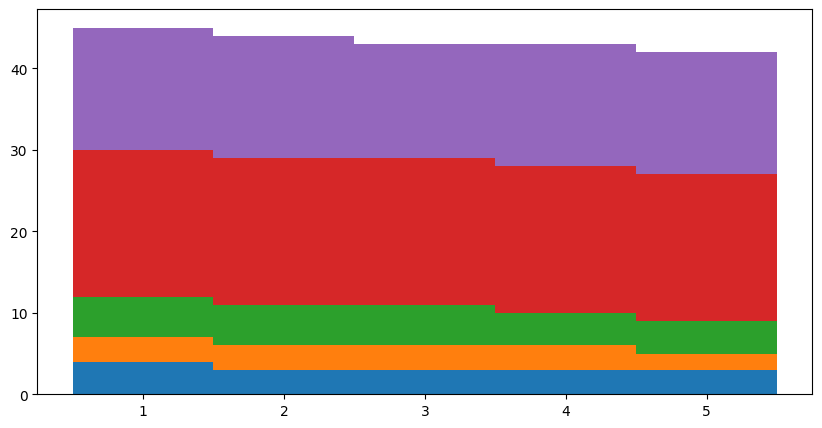

In [24]:
# Now the number of CMEs by verif level (stack) one column per split (we have to group)

ncmedf = df.groupby(['split', 'subsplit']).sum().reset_index()

fig, ax = plt.subplots(figsize=(10, 5))

width = 1

ax.bar(ncmedf["split"], ncmedf["n_cme_level_1"], label="Verification level 1", width=width)
ax.bar(ncmedf["split"], ncmedf["n_cme_level_2"], bottom=ncmedf["n_cme_level_1"], label="Verification level 2", width=width)
ax.bar(ncmedf["split"], ncmedf["n_cme_level_3"], bottom=ncmedf["n_cme_level_1"]+ncmedf["n_cme_level_2"], label="Verification level 3", width=width)
ax.bar(ncmedf["split"], ncmedf["n_cme_level_4"], bottom=ncmedf["n_cme_level_1"]+ncmedf["n_cme_level_2"]+ncmedf["n_cme_level_3"], label="Verification level 4", width=width)
ax.bar(ncmedf["split"], ncmedf["n_cme_level_5"], bottom=ncmedf["n_cme_level_1"]+ncmedf["n_cme_level_2"]+ncmedf["n_cme_level_3"]+ncmedf["n_cme_level_4"], label="Verification level 5", width=width)